In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
drive_path = "/content/drive/MyDrive/dataset.zip"
destination_path = "/content/"

In [3]:
!cp $drive_path $destination_path

In [4]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
   creating: dataset/
   creating: dataset/annual mallow/
  inflating: dataset/annual mallow/image_02862.jpg  
  inflating: dataset/annual mallow/image_02863.jpg  
  inflating: dataset/annual mallow/image_02864.jpg  
  inflating: dataset/annual mallow/image_02865.jpg  
  inflating: dataset/annual mallow/image_02866.jpg  
  inflating: dataset/annual mallow/image_02867.jpg  
  inflating: dataset/annual mallow/image_02868.jpg  
  inflating: dataset/annual mallow/image_02869.jpg  
  inflating: dataset/annual mallow/image_02870.jpg  
  inflating: dataset/annual mallow/image_02871.jpg  
  inflating: dataset/annual mallow/image_02872.jpg  
  inflating: dataset/annual mallow/image_02873.jpg  
  inflating: dataset/annual mallow/image_02874.jpg  
  inflating: dataset/annual mallow/image_02875.jpg  
  inflating: dataset/annual mallow/image_02876.jpg  
  inflating: dataset/annual mallow/image_02877.jpg  
  inflating: dataset/annual mallow/image_02878.jpg  
  inflatin

In [5]:
from PIL import ImageOps, Image, ImageEnhance
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import os

In [20]:
def random_rotation(image, degrees=30):
    angle = np.random.uniform(-degrees, degrees)
    radians = np.deg2rad(angle)
    height, width = image.shape[:2]
    # Compute rotation matrix
    rotation_matrix = np.array([
        [np.cos(radians), -np.sin(radians)],
        [np.sin(radians), np.cos(radians)]
    ])
    # Compute new image dimensions
    corners = np.array([
        [0, 0],
        [0, height],
        [width, 0],
        [width, height]
    ])
    new_corners = np.dot(corners - np.array([width / 2, height / 2]), rotation_matrix.T) + np.array([width / 2, height / 2])
    new_width, new_height = new_corners[:, 0].ptp(), new_corners[:, 1].ptp()

    # Create an empty output image
    rotated_image = np.zeros((int(new_height), int(new_width), *image.shape[2:]), dtype=image.dtype)

    # Iterate through each pixel in the output image
    for y in range(rotated_image.shape[0]):
        for x in range(rotated_image.shape[1]):
            # Compute corresponding source coordinates
            source_coords = np.dot([x - new_width / 2, y - new_height / 2], rotation_matrix) + [width / 2, height / 2]
            sx, sy = source_coords
            if 0 <= sx < width and 0 <= sy < height:
                rotated_image[y, x] = image[int(sy), int(sx)]

    return rotated_image
def random_brightness(image, factor_range=(0.8, 1.2)):
    factor = np.random.uniform(*factor_range)

    # Scale pixel values and clip to maintain valid range
    brightened_image = np.clip(image * factor, 0, 255).astype(image.dtype)

    return brightened_image

def random_resized_crop(image, size):
    # Resize the image to 256 on the shorter side while maintaining aspect ratio
    width, height = image.size
    if width < height:
        new_width = 256
        new_height = int(256 * height / width)
    else:
        new_height = 256
        new_width = int(256 * width / height)

    resized_image = image.resize((new_width, new_height), Image.BILINEAR)

    # Perform random crop of size x size
    crop_x = np.random.randint(0, new_width - size + 1)
    crop_y = np.random.randint(0, new_height - size + 1)
    cropped_image = resized_image.crop((crop_x, crop_y, crop_x + size, crop_y + size))

    return cropped_image


def random_horizontal_flip(image, probability=0.5):
    if np.random.rand() < probability:
        return ImageOps.mirror(image)
    return image
def random_vertical_flip(image, probability=0.5):
    if np.random.rand() < probability:
        return ImageOps.flip(image)
    return image
def resize(image, size):
    return image.resize((size, size), Image.BILINEAR)
def center_crop(image, size):
    width, height = image.size
    left = (width - size) // 2
    top = (height - size) // 2
    return image.crop((left, top, left + size, top + size))

def to_tensor(image):
    return np.array(image).transpose(2, 0, 1) / 255.0
def normalize(tensor, mean, std):
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    return (tensor - mean) / std

In [7]:
torch.manual_seed(42)

In [8]:
data_dir = "/content/dataset"
#
checkpoint_dir = "/content/drive/MyDrive/checkpoints/"
base_name = "resnet50_3e4_10_secondTry2_"

In [9]:
class FlowerClassifier(nn.Module):
    def __init__(self, num_classes=25):
        super(FlowerClassifier, self).__init__()
        #
        self.backbone = models.resnet50(pretrained=True)
        #
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [10]:
model = FlowerClassifier(num_classes=27)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


In [11]:
#
def train_transform(image):
    image = random_resized_crop(image, size=224)
    image = random_horizontal_flip(image)
    image = random_vertical_flip(image)
    image = random_rotation(image, degrees=30)
    image = random_brightness(image, factor_range=(0.8, 1.2))
    tensor = to_tensor(image)
    return normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def val_test_transform(image):
    """Apply resizing and normalization for validation/testing."""
    image = resize(image, size=256)
    image = center_crop(image, size=224)
    tensor = to_tensor(image)
    return normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#
full_dataset = datasets.ImageFolder(root=data_dir)

#
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

#
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform
#
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
print("Class names:")
for idx, class_name in enumerate(full_dataset.classes):
    print(f"{idx}: {class_name}")

Class names:
0: annual mallow
1: asian virginsbower
2: barbados lily
3: bull thistle
4: buttercup
5: california poppies
6: calla lily
7: canna lily
8: coltsfoot
9: common columbine
10: common cornflag
11: common daisy
12: common dandelion
13: common primroses
14: corn poppy
15: desert rose
16: fritillaries
17: garden petunia
18: passionflower
19: peruvian lily
20: scarlet beebalm
21: sunflower
22: tea roses
23: tiger lily
24: violets
25: wallflowers
26: water lillies


In [13]:
#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [14]:
#
num_epochs = 10
best_loss = float('inf')  #

In [15]:
#
def test_model(model, test_loader, header):
    model.eval()  #
    correct = 0
    total = 0

    with torch.no_grad():  #
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"{header} Accuracy: {accuracy:.4f}%")
    return accuracy

In [16]:
for epoch in range(num_epochs):
    print(f"Current Epoch: {epoch}")
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    #
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch rn: [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
    test_model(model, val_loader, "Validation")

    #
    if epoch_loss < best_loss:
      accuracy_test = test_model(model, test_loader, "Test")
      best_loss = epoch_loss
      checkpoint_path = os.path.join(checkpoint_dir, f"{base_name}_epoch_{epoch+1}_accuracy_test_{accuracy_test:.4f}.pth")
      torch.save(model.state_dict(), checkpoint_path)
      print(f"Checkpoint saved at {checkpoint_path}")

print("Training complete!")

Current Epoch: 0
Epoch rn: [1/10], Train Loss: 0.9285
Validation Accuracy: 81.5498%
Test Accuracy: 80.5147%
Checkpoint saved at /content/drive/MyDrive/checkpoints/resnet50_3e4_10_secondTry2__epoch_1_accuracy_test_80.5147.pth
Current Epoch: 1
Epoch rn: [2/10], Train Loss: 0.3347
Validation Accuracy: 79.7048%
Test Accuracy: 84.9265%
Checkpoint saved at /content/drive/MyDrive/checkpoints/resnet50_3e4_10_secondTry2__epoch_2_accuracy_test_84.9265.pth
Current Epoch: 2
Epoch rn: [3/10], Train Loss: 0.2118
Validation Accuracy: 92.6199%
Test Accuracy: 93.0147%
Checkpoint saved at /content/drive/MyDrive/checkpoints/resnet50_3e4_10_secondTry2__epoch_3_accuracy_test_93.0147.pth
Current Epoch: 3
Epoch rn: [4/10], Train Loss: 0.0876
Validation Accuracy: 95.5720%
Test Accuracy: 98.1618%
Checkpoint saved at /content/drive/MyDrive/checkpoints/resnet50_3e4_10_secondTry2__epoch_4_accuracy_test_98.1618.pth
Current Epoch: 4
Epoch rn: [5/10], Train Loss: 0.1279
Validation Accuracy: 89.1144%
Current Epoch: 5

In [18]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 98.5 MB/s eta 0:00:00


In [19]:
# DONT FORGET TO ADD RESIZE AND NORMALIZATION WHEN RUNNING ONNX GRAPH
# DONT FORGET TO ADD RESIZE AND NORMALIZATION WHEN RUNNING ONNX GRAPH
# DONT FORGET TO ADD RESIZE AND NORMALIZATION WHEN RUNNING ONNX GRAPH
# like this: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
import onnx

input_tensor = torch.rand((1, 3, 224, 224), dtype=torch.float32)

checkpoint_path = os.path.join(checkpoint_dir, '/content/drive/MyDrive/checkpoints/resnet50_3e4_10_secondTry2__epoch_4_accuracy_test_98.1618.pth')  # Use the actual epoch name if needed

model = FlowerClassifier(num_classes=27)  # Reinitialize the model architecture
model.load_state_dict(torch.load(checkpoint_path))

torch.onnx.export(
    model,                  # model to export
    (input_tensor,),        # inputs of the model resized,
    checkpoint_path.replace(".pth", ".onnx"),        # filename of the ONNX model
    input_names=["input"],  # Rename inputs for the ONNX model
)

# like this: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# DONT FORGET TO ADD RESIZE AND NORMALIZATION WHEN RUNNING ONNX GRAPH
# DONT FORGET TO ADD RESIZE AND NORMALIZATION WHEN RUNNING ONNX GRAPH
# DONT FORGET TO ADD RESIZE AND NORMALIZATION WHEN RUNNING ONNX GRAPH


<ipython-input-19-c981fd2ebd4f>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


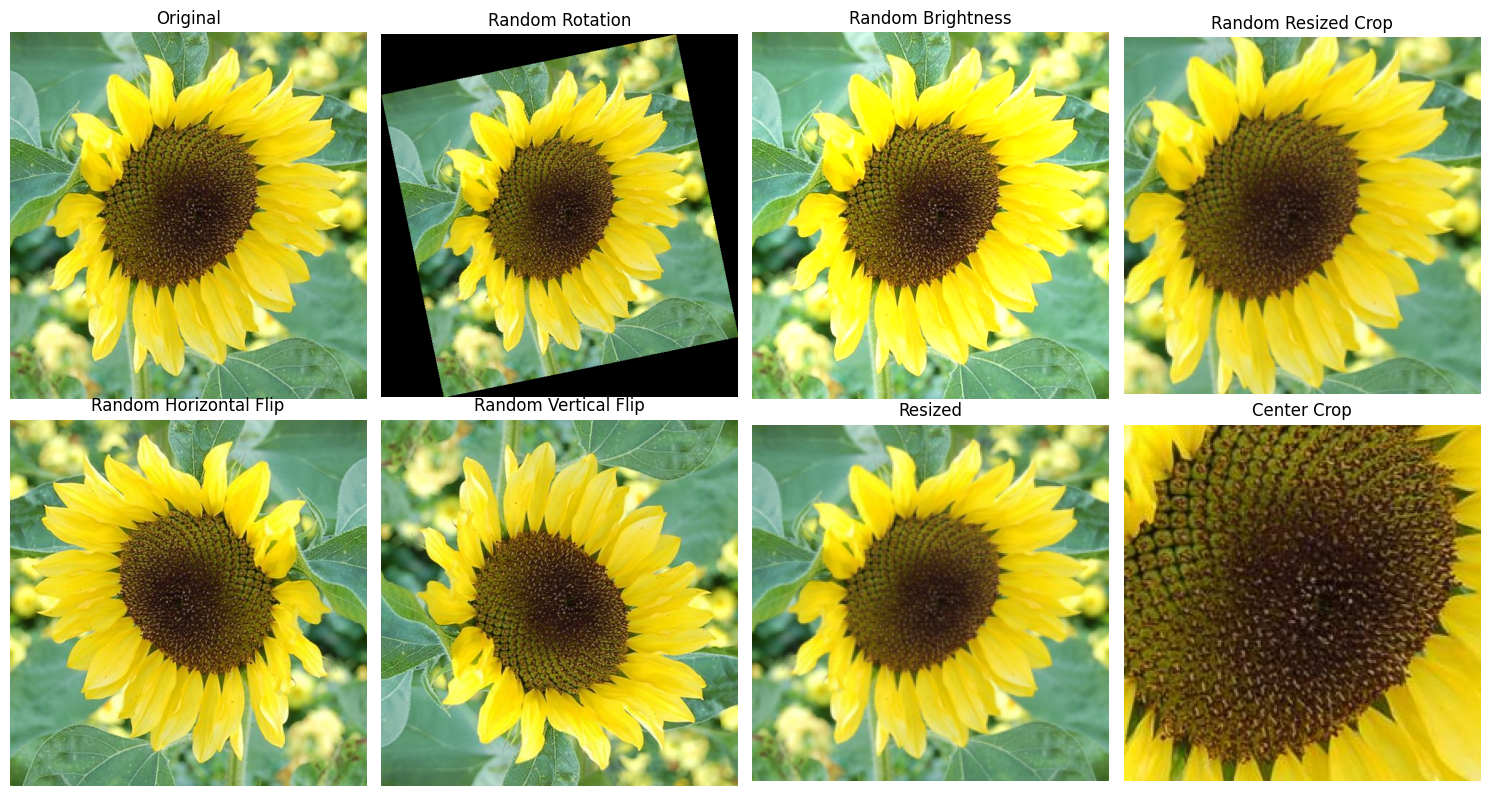

In [24]:
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
import matplotlib.pyplot as plt

# Define all your transformation functions here (already provided in your code)

def apply_transformations(image_path):
    """
    Apply a series of transformations to an image and display the results.

    Parameters:
        image_path (str): Path to the input image.
    """
    # Load the image
    original_image = Image.open(image_path).convert("RGB")

    # Initialize a list to hold images and their titles
    transformations = []

    # Original image
    transformations.append(("Original", original_image))

    # Apply random rotation
    rotated_image = random_rotation(np.array(original_image))
    transformations.append(("Random Rotation", Image.fromarray(rotated_image)))

    # Apply random brightness
    brightened_image = random_brightness(np.array(original_image))
    transformations.append(("Random Brightness", Image.fromarray(brightened_image)))

    # Apply random resized crop
    resized_cropped_image = random_resized_crop(original_image, size=224)
    transformations.append(("Random Resized Crop", resized_cropped_image))

    # Apply random horizontal flip
    horizontal_flipped_image = random_horizontal_flip(original_image)
    transformations.append(("Random Horizontal Flip", horizontal_flipped_image))

    # Apply random vertical flip
    vertical_flipped_image = random_vertical_flip(original_image)
    transformations.append(("Random Vertical Flip", vertical_flipped_image))

    # Apply resizing
    resized_image = resize(original_image, size=224)
    transformations.append(("Resized", resized_image))

    # Apply center crop
    center_cropped_image = center_crop(original_image, size=224)
    transformations.append(("Center Crop", center_cropped_image))

    # Plot all the images
    plt.figure(figsize=(15, 8))
    for i, (title, img) in enumerate(transformations):
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Path to your image
image_path = "/content/dataset/sunflower/image_05399.jpg"
# Apply transformations and display results
apply_transformations(image_path)